/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


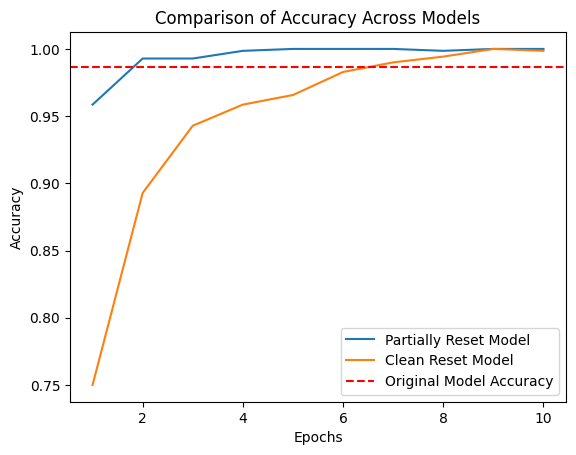

(0.9866666793823242, 1.0, 1.0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import tensorflow as tf

# Step 1: Create a simple dataset (e.g., two interleaving moons for classification)
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Define a simple neural network for classification
def create_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(2,),
              kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.)),
        Dense(16, activation='relu', kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.)),
        Dense(1, activation='sigmoid', kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.))
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 3: Train the model and save initial weights
original_model = create_model()
original_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Save original weights
original_weights = [layer.get_weights() for layer in original_model.layers]

# Step 4: Reset weights partially (introduce controlled residual states)
def reset_weights_with_residuals(model, original_weights, noise_factor=0.2):
    for i, layer in enumerate(model.layers):
        if len(original_weights[i]) > 0:  # Skip layers without weights
            weights, biases = original_weights[i]
            # Add controlled noise to weights
            noisy_weights = weights + noise_factor * np.random.normal(size=weights.shape)
            layer.set_weights([noisy_weights, biases])

# Step 5: Train partially reset model
partially_reset_model = create_model()
reset_weights_with_residuals(partially_reset_model, original_weights, noise_factor=0.2)
history_partially_reset = partially_reset_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Step 6: Train clean-reset model
clean_reset_model = create_model()
history_clean_reset = clean_reset_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Step 7: Evaluate and compare results
accuracy_original = original_model.evaluate(X_test, y_test, verbose=0)[1]
accuracy_partially_reset = partially_reset_model.evaluate(X_test, y_test, verbose=0)[1]
accuracy_clean_reset = clean_reset_model.evaluate(X_test, y_test, verbose=0)[1]

# Step 8: Visualize results
epochs = range(1, 11)
plt.plot(epochs, history_partially_reset.history['accuracy'], label="Partially Reset Model")
plt.plot(epochs, history_clean_reset.history['accuracy'], label="Clean Reset Model")
plt.axhline(y=accuracy_original, color='r', linestyle='--', label="Original Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy Across Models")
plt.legend()
plt.show()

# Output results
accuracy_original, accuracy_partially_reset, accuracy_clean_reset


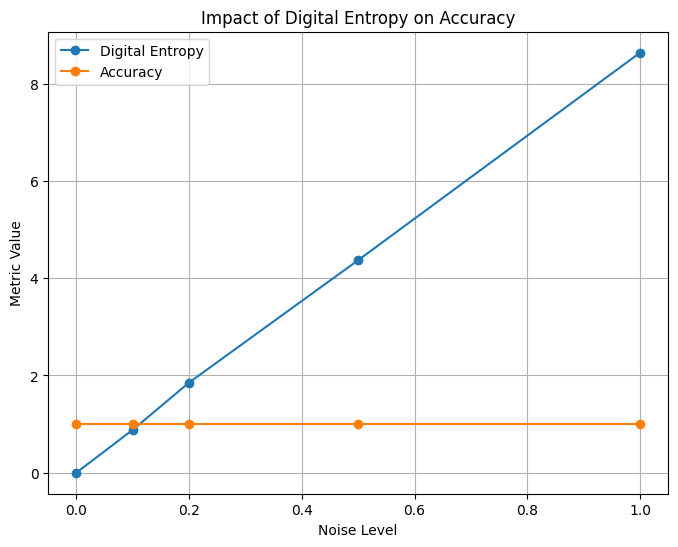

[(0.0, 0.0, 1.0),
 (0.1, 0.8822070275960846, 1.0),
 (0.2, 1.85377797380029, 1.0),
 (0.5, 4.37101915208702, 1.0),
 (1.0, 8.638293172844753, 1.0)]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import tensorflow as tf

# Step 1: Define a simple dataset (e.g., two interleaving moons for classification)
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Define a helper function to create a simple neural network
def create_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(2,),
              kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.)),
        Dense(16, activation='relu', kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.)),
        Dense(1, activation='sigmoid', kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.))
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 3: Train the original model and save its weights
original_model = create_model()
original_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
original_weights = [layer.get_weights() for layer in original_model.layers]

# Step 4: Define a function to calculate digital entropy (difference in weights)
def calculate_entropy(original_weights, reset_weights):
    entropies = []
    for orig, reset in zip(original_weights, reset_weights):
        if len(orig) > 0:
            orig_weights, _ = orig
            reset_weights, _ = reset
            # Frobenius norm as entropy metric
            entropy = np.linalg.norm(orig_weights - reset_weights, ord='fro')
            entropies.append(entropy)
    return np.mean(entropies)

# Step 5: Experiment with different noise levels and measure entropy
noise_levels = [0.0, 0.1, 0.2, 0.5, 1.0]
entropy_results = []
accuracy_results = []

for noise in noise_levels:
    model = create_model()
    reset_weights = []
    for i, layer in enumerate(model.layers):
        if len(original_weights[i]) > 0:
            weights, biases = original_weights[i]
            noisy_weights = weights + noise * np.random.normal(size=weights.shape)
            layer.set_weights([noisy_weights, biases])
            reset_weights.append([noisy_weights, biases])
        else:
            reset_weights.append([])

    # Calculate digital entropy
    entropy = calculate_entropy(original_weights, reset_weights)
    entropy_results.append(entropy)

    # Train the model with noisy weights and evaluate
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    accuracy_results.append(accuracy)

# Step 6: Visualize entropy vs. accuracy
plt.figure(figsize=(8, 6))
plt.plot(noise_levels, entropy_results, label="Digital Entropy", marker='o')
plt.plot(noise_levels, accuracy_results, label="Accuracy", marker='o')
plt.xlabel("Noise Level")
plt.ylabel("Metric Value")
plt.title("Impact of Digital Entropy on Accuracy")
plt.legend()
plt.grid()
plt.show()

# Output results
list(zip(noise_levels, entropy_results, accuracy_results))

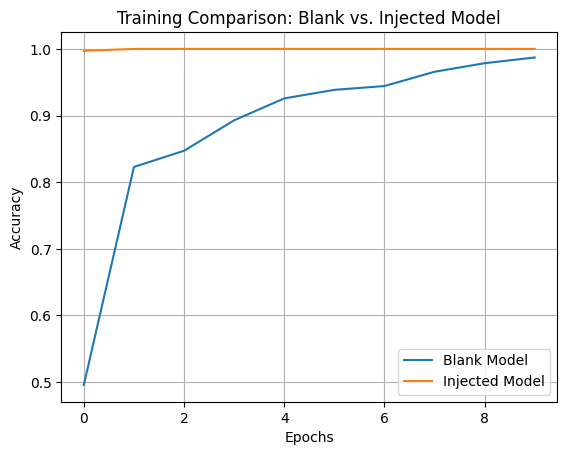

Blank Model Accuracy:  0.996666669845581
Injected Model Accuracy:  1.0


In [ ]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import matplotlib.pyplot as plt

# Step 1: Create a simple dataset (e.g., two interleaving moons for classification)
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Define a helper function to create a simple neural network
def create_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(2,),
              kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.)),
        Dense(16, activation='relu', kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.)),
        Dense(1, activation='sigmoid', kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.))
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 3: Train the original model to generate residual states
original_model = create_model()
original_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Save the trained weights from the original model
original_weights = [layer.get_weights() for layer in original_model.layers]

# Step 4: Create a blank model with randomly initialized weights
blank_model = create_model()
blank_weights = [layer.get_weights() for layer in blank_model.layers]

# Step 5: Inject "digital entropy" (ghost memory) into the blank model
injected_model = create_model()
for i, layer in enumerate(injected_model.layers):
    if len(original_weights[i]) > 0:  # Skip layers without weights
        orig_w, orig_b = original_weights[i]
        blank_w, blank_b = blank_weights[i]
        # Calculate the residual (digital entropy)
        residual_w = orig_w - blank_w
        # Inject residuals into the blank model's weights
        injected_w = blank_w + residual_w
        layer.set_weights([injected_w, orig_b])

# Step 6: Train both the blank and entropy-injected models
history_blank = blank_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
history_injected = injected_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Step 7: Evaluate and compare the models on the test set
accuracy_blank = blank_model.evaluate(X_test, y_test, verbose=0)[1]
accuracy_injected = injected_model.evaluate(X_test, y_test, verbose=0)[1]

# Step 8: Visualize training accuracy over epochs
plt.plot(history_blank.history['accuracy'], label="Blank Model")
plt.plot(history_injected.history['accuracy'], label="Injected Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Comparison: Blank vs. Injected Model")
plt.legend()
plt.grid()
plt.show()

# Step 9: Output results
print("Blank Model Accuracy: ", accuracy_blank)
print("Injected Model Accuracy: ", accuracy_injected)

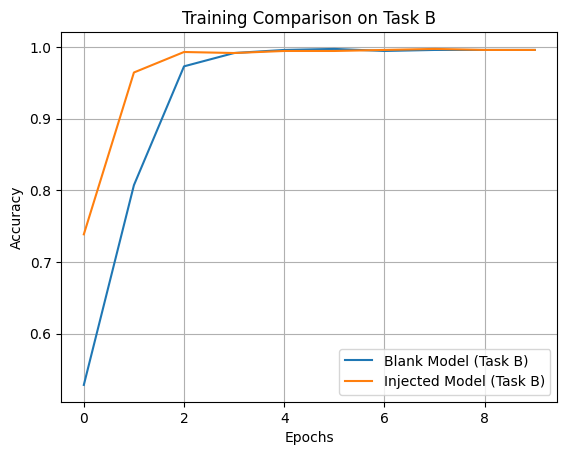

Blank Model Accuracy on Task B:  0.9866666793823242
Injected Model Accuracy on Task B:  0.9933333396911621


In [ ]:
import numpy as np
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import matplotlib.pyplot as plt

# Helper function to create a model
def create_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(2,),
              kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.)),
        Dense(16, activation='relu', kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.)),
        Dense(1, activation='sigmoid', kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.))
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 1: Task A - Train model on the moons dataset
X_taskA, y_taskA = make_moons(n_samples=1000, noise=0.1, random_state=42)
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X_taskA, y_taskA, test_size=0.3, random_state=42)

model_taskA = create_model()
model_taskA.fit(X_trainA, y_trainA, epochs=10, batch_size=32, verbose=0)
original_weights = [layer.get_weights() for layer in model_taskA.layers]

# Step 2: Task B - Concentric Circles dataset
X_taskB, y_taskB = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42)
X_trainB, X_testB, y_trainB, y_testB = train_test_split(X_taskB, y_taskB, test_size=0.3, random_state=42)

# Step 3: Inject Task A residuals into a blank model for Task B
blank_model = create_model()
blank_weights = [layer.get_weights() for layer in blank_model.layers]

injected_model = create_model()
for i, layer in enumerate(injected_model.layers):
    if len(original_weights[i]) > 0:  # Skip layers without weights
        orig_w, orig_b = original_weights[i]
        blank_w, blank_b = blank_weights[i]
        # Calculate and inject residuals
        residual_w = orig_w - blank_w
        injected_w = blank_w + residual_w
        layer.set_weights([injected_w, orig_b])

# Step 4: Train both models on Task B
history_blank = blank_model.fit(X_trainB, y_trainB, epochs=10, batch_size=32, verbose=0)
history_injected = injected_model.fit(X_trainB, y_trainB, epochs=10, batch_size=32, verbose=0)

# Step 5: Evaluate and compare results on Task B
accuracy_blank = blank_model.evaluate(X_testB, y_testB, verbose=0)[1]
accuracy_injected = injected_model.evaluate(X_testB, y_testB, verbose=0)[1]

# Step 6: Visualize the results
plt.plot(history_blank.history['accuracy'], label="Blank Model (Task B)")
plt.plot(history_injected.history['accuracy'], label="Injected Model (Task B)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Comparison on Task B")
plt.legend()
plt.grid()
plt.show()

# Output final accuracies
print("Blank Model Accuracy on Task B: ", accuracy_blank)
print("Injected Model Accuracy on Task B: ", accuracy_injected)

In [ ]:
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import matplotlib.pyplot as plt

# Helper function to create a model
def create_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(2,),
              kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.)),
        Dense(16, activation='relu', kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.)),
        Dense(1, activation='sigmoid', kernel_initializer=initializers.RandomNormal(mean=0., stddev=1.))
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 1: Generate datasets for Task A, B, and C
X_taskA, y_taskA = make_moons(n_samples=1000, noise=0.1, random_state=42)
X_taskB, y_taskB = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,  # All features are informative
    n_redundant=0,    # No redundant features
    n_repeated=0,     # No repeated features
    n_classes=2,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=42
)
X_taskC, y_taskC = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42)

datasets = [
    (X_taskA, y_taskA, "Task A"),
    (X_taskB, y_taskB, "Task B"),
    (X_taskC, y_taskC, "Task C")
]

# Step 2: Train individual models on each task and collect residuals
residuals = []
for X, y, task_name in datasets:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = create_model()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    residuals.append([layer.get_weights() for layer in model.layers])

# Step 3: Inject residuals sequentially and evaluate the model
multi_task_model = create_model()
results = []

# Inject residuals one by one and test after each injection
for i, (res, (X, y, task_name)) in enumerate(zip(residuals, datasets)):
    for layer_idx, layer in enumerate(multi_task_model.layers):
        if len(res[layer_idx]) > 0:  # Skip layers without weights
            layer.set_weights(res[layer_idx])

    # Evaluate the model on all tasks after each injection
    task_results = {}
    for X_test, y_test, test_task_name in datasets:
        _, accuracy = multi_task_model.evaluate(X_test, y_test, verbose=0)
        task_results[test_task_name] = accuracy
    results.append((f"After injecting {task_name}", task_results))

# Step 4: Display results
for injection_step, task_results in results:
    print(injection_step)
    for task_name, accuracy in task_results.items():
        print(f"  {task_name} Accuracy: {accuracy}")

After injecting Task A
  Task A Accuracy: 0.9620000123977661
  Task B Accuracy: 0.07400000095367432
  Task C Accuracy: 0.5400000214576721
After injecting Task B
  Task A Accuracy: 0.24300000071525574
  Task B Accuracy: 0.9929999709129333
  Task C Accuracy: 0.4959999918937683
After injecting Task C
  Task A Accuracy: 0.6840000152587891
  Task B Accuracy: 0.5009999871253967
  Task C Accuracy: 0.9909999966621399
